# Questionnaires analysis

This notebook contains the analysis of questionnaires files.

The first part of the notebook is based on the control questionnaire filled right before the study.
Emotion analysis in the latter part uses participants' answers from the emotion questionnaires presented after each stimulus.

## Setup

In [1]:
import os
import json
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
# general settings
from helpers import PARTICIPANTS_ID, EMOTIONS_SAM

tex_fonts = {
    # set font
    'font.family': 'sans-serif',
    'font.sans-serif': 'Calibri',
    
    # Use 8pt font in plots
    'axes.titlesize': 8,
    'axes.titlepad': 3,
    'axes.labelsize': 8,
    'font.size': 8,
    
    # Set the legend/label/grid
    'legend.fontsize': 8,
    "xtick.labelsize": 6,
    'axes.labelpad': 1.0,
    'xtick.major.pad': 1,
    'xtick.major.size': 1,
    "ytick.labelsize": 8,
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'axes.facecolor':'white',
    'figure.facecolor':'white',
    'grid.color': 'black',
    'grid.alpha': .3,
}

sns.set(rc=tex_fonts)

# boxplot style 
PROPS = {
    'boxprops':{'linewidth':.5},
    'medianprops':{'linestyle':'-', 'color':'black', 'linewidth':1.2},
    'whiskerprops':{'linewidth':.8},
    'capprops':{'linewidth':.8, 'color':'black'}
}

In [3]:
config = configparser.ConfigParser()
config.read("config.ini")

if not os.path.exists(config['DataDirectories']['unzipped_dataset']):
    raise Exception("Please set path for unzipped dataset in config.ini file")

DATA_DIR = config['DataDirectories']['unzipped_dataset']
all_questionnaire_files = [f'{DATA_DIR}/{participant_id}/{participant_id}_questionnaires.json' for participant_id in PARTICIPANTS_ID]
SAVE_DIR = './'

MOVIES_WITH_LABELS = [
    ('AMUSEMENT', 'AM'),
    ('ANGER', 'AN'),
    ('AWE', 'AW'),
    ('DISGUST', 'D'),
    ('ENTHUSIASM', 'E'),
    ('FEAR', 'F'),
    ('LIKING', 'L'),
    ('SADNESS', 'SA'),
    ('SURPRISE', 'SU'), 
    ('BASELINE', 'B'),
    ('NEUTRAL', 'N')
]

COLORS = ["#dc9e40", "#9aafdc", "#9cc279", "#ced9ef"]

In [4]:
EMOTIONS = [M for M, _ in MOVIES_WITH_LABELS if M not in {'BASELINE', 'NEUTRAL'}]
EMOTIONS_LABELS = [L for M, L in MOVIES_WITH_LABELS if M not in {'BASELINE', 'NEUTRAL'}]
MOVIES = [M for M, _ in MOVIES_WITH_LABELS]
MOVIES_LABELS = [L for _, L in MOVIES_WITH_LABELS]

In [5]:
EMOTIONS_SAM

('VALENCE', 'AROUSAL', 'MOTIVATION')

## Get data from questionnaires

In [6]:
genders_ages, drugs = [], []
movies_ratings = {M:[] for M in MOVIES}
emotions_ratings = {E:{M:dict() for M in MOVIES} for E in EMOTIONS + list(EMOTIONS_SAM)}
film_seen_before_study = pd.DataFrame(0, index=[0], columns=sorted(EMOTIONS + ['NEUTRAL']))

for f_path in tqdm(all_questionnaire_files):
    with open(f_path, 'r') as f:
        f_dict = json.load(f)
    part_id = f_dict['metadata']['id']
    drugs.append(f_dict['metadata']['other_drugs_in_last_8h'])
    
    # genders and ages list
    genders_ages.append(
        pd.DataFrame(
            data={
                'age':f_dict['metadata']['age'],
                'gender':f_dict['metadata']['gender']
            },
            index=[part_id]
        )
    )

    # films seen before study
    seen_films_data = {k.upper():v for k,v in f_dict['metadata']['movie_seen_before_study'].items()}
    film_seen_before_study += pd.DataFrame(seen_films_data, [0])

    # questionnaires list
    questionnaires = f_dict['questionnaires']
    
    # for each questionnaire append dataframe containing answers 
    # to appropriate list in movies_ratings dict
    for q in questionnaires:
        # within conditions
        data = pd.DataFrame(
            data={**q['emotions'], **q['sam']},
            index=[part_id]
        )
        movies_ratings[q['movie']].append(data)

        # between conditions
        for emotion, rating in {**q['emotions'], **q['sam']}.items():
            emotions_ratings[emotion][q['movie']].setdefault(part_id, rating)

genders_ages = pd.concat(genders_ages, ignore_index=False)
movies_ratings = {m:pd.concat(l, ignore_index=False) for m,l in movies_ratings.items()}
emotions_ratings = {e:pd.DataFrame(m) for e, m in emotions_ratings.items()}

  0%|          | 0/43 [00:00<?, ?it/s]

## Control questionnaire analysis

In [7]:
print('Participants after drugs:', [i+22 for i, tf in enumerate(drugs) if tf])

Participants after drugs: [25, 44]


([<matplotlib.axis.XTick at 0x190255a7908>,
 <a list of 11 Text xticklabel objects>)

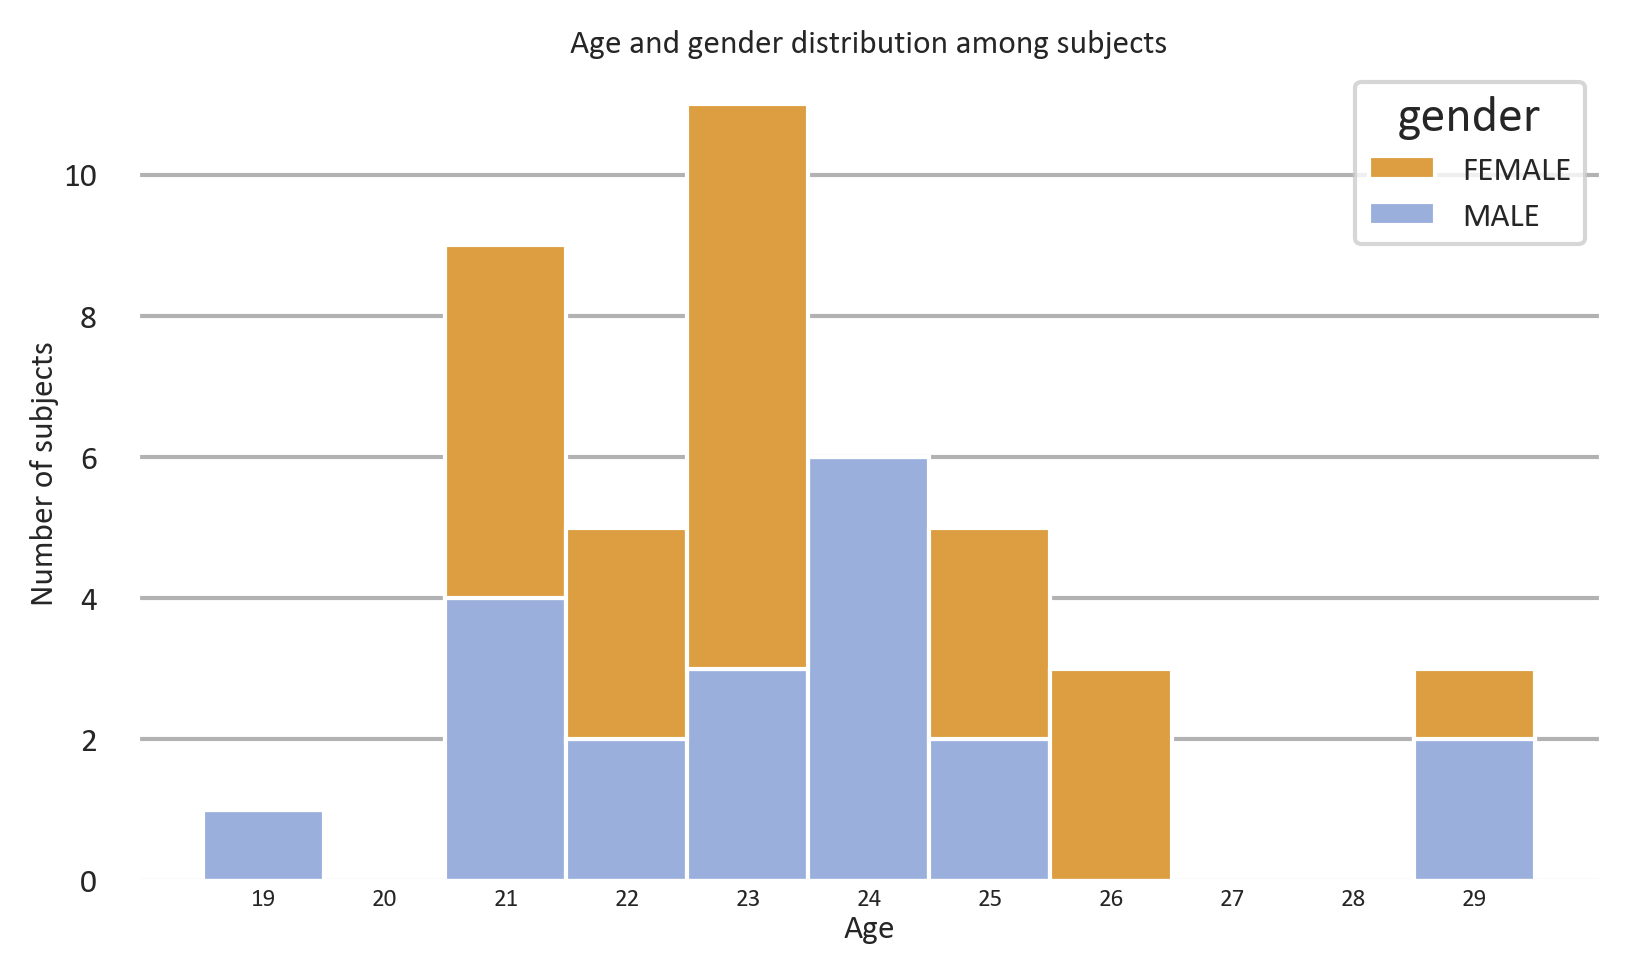

In [8]:
# subjects' age and gender
fig = plt.figure(figsize=(6.3, 3.6), dpi=300)
sns.histplot(genders_ages, x='age', hue='gender', multiple="stack", bins=range(19, 30), palette=COLORS[:2], alpha=1., discrete=True)
plt.title(f'Age and gender distribution among subjects')
plt.xlabel('Age')
plt.ylabel('Number of subjects')
plt.xticks(range(19,30))

Text(0.5, 1.0, 'Movies seen by subjects before study')

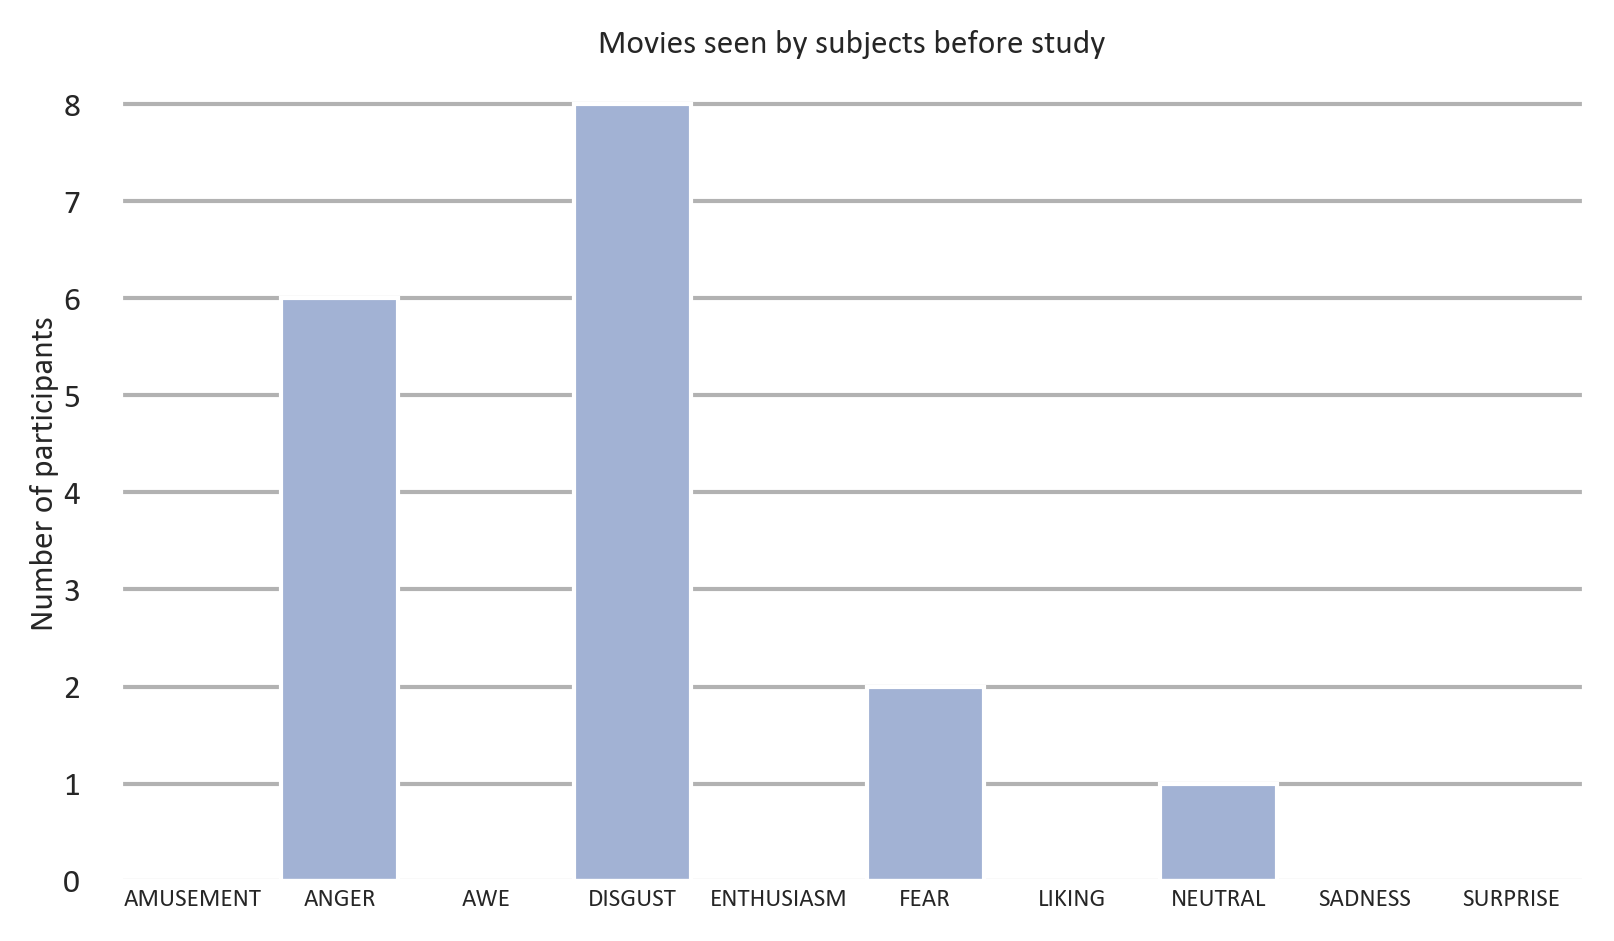

In [9]:
# movies seen before study
fig = plt.figure(figsize=(6.3, 3.6), dpi=300)
sns.barplot(data=film_seen_before_study, color=COLORS[1])
plt.ylabel('Number of participants')
plt.title('Movies seen by subjects before study')

## Analysis of emotions

Analysis of emotions **within conditions** shows how different emotions were scored after a particular stimulus (scores for all emotions in a questionnaire after e.g. angry, sad, etc. film clips). 

Analysis of emotions **between conditions** shows how the particular emotion was scored after different stimuli (e.g. amusement after amusing, angry, baseline, etc. film clips).

For more info and detailed description please see the article [Emognition dataset: emotion recognition with self-reports, facial expressions, and physiology using wearables](https://doi.org/10.7910/DVN/R9WAF4).

### Emotions within conditions

In [10]:
emotions_within_palette = [COLORS[1]]*9

def boxplots_emotions_within(movies_ratings, stimulus_type, pos=[], emotions_range=range(1, 5+1), palette=['#9aafdc']*9):
    # EMOTION questionnaires box plots
    df_to_plot = movies_ratings[stimulus_type][EMOTIONS]
    # plotting
    g = sns.boxplot(data=df_to_plot, orient='v', palette=palette, width=0.8, whis=[5, 95], fliersize=2, **PROPS)
    plt.ylim((0.3, 5.5))
    plt.title(f'{stimulus_type}')
    
    if 'left' in pos:
        g.set(yticks=emotions_range, yticklabels = emotions_range)
    else:
        g.set(yticks=emotions_range, yticklabels = [])
        
    if 'bottom' in pos:
        g.set(xticklabels=EMOTIONS_LABELS)
    else:
        g.set(xticklabels=[])

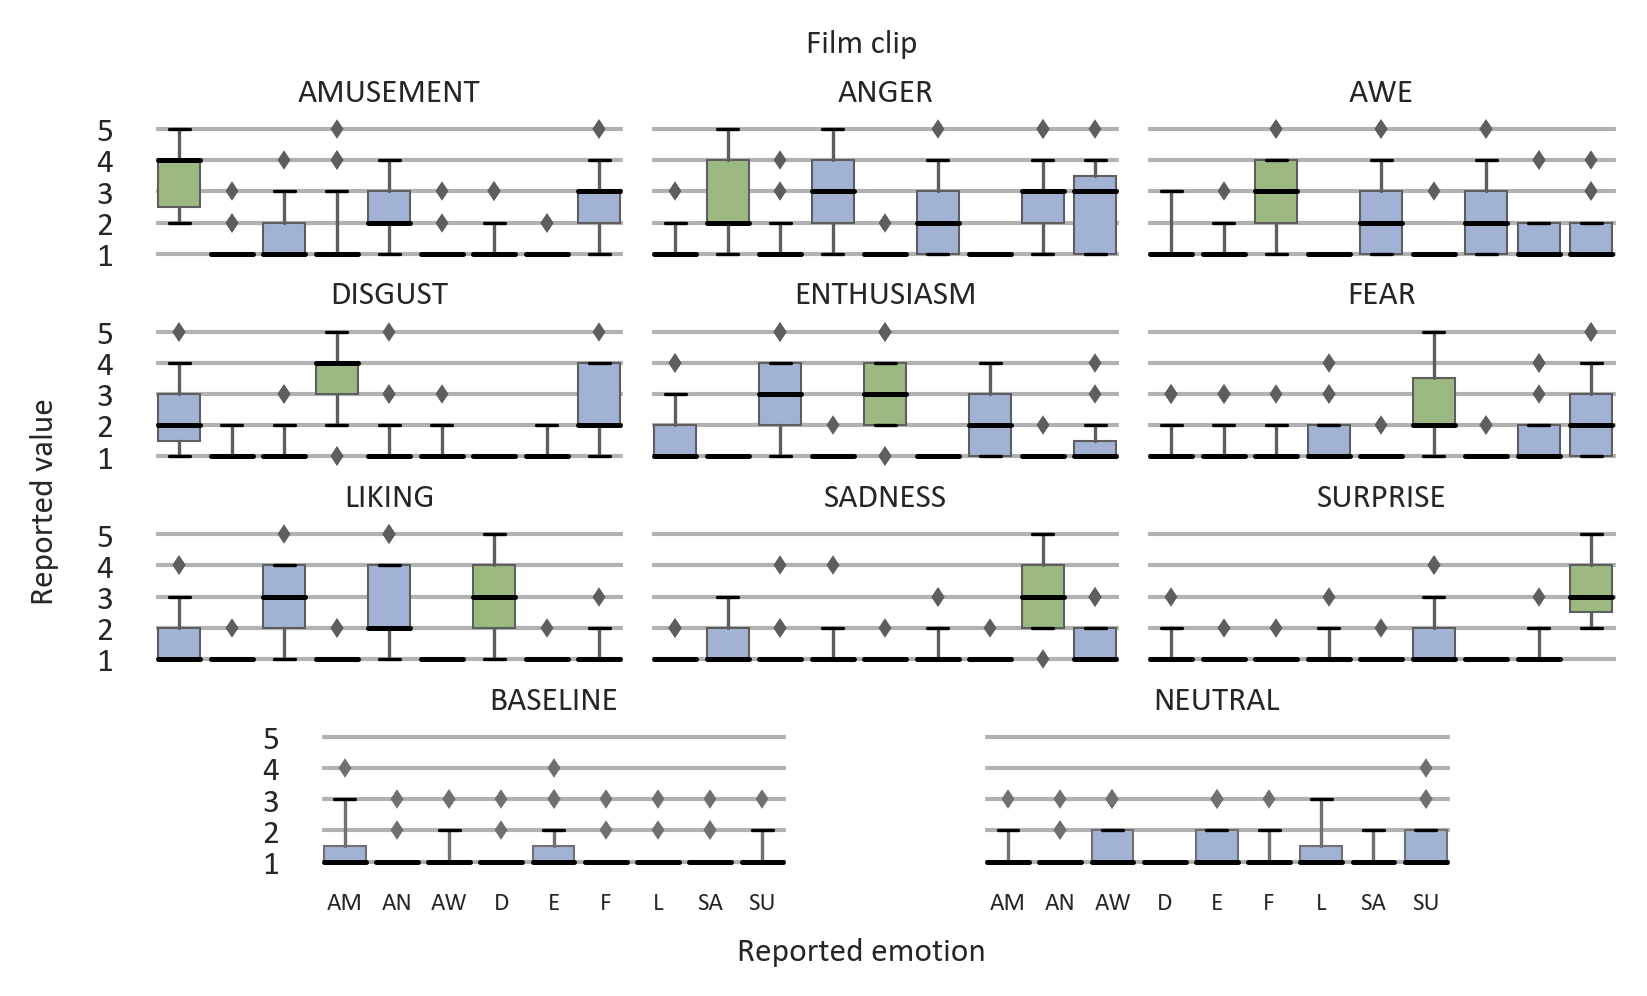

In [11]:
fig = plt.figure(figsize=(6.3, 3.4), constrained_layout=False, dpi=300)
gs0 = fig.add_gridspec(nrows=4, ncols=1, hspace=0.25)
gs01 = gs0[-1].subgridspec(1, 9)

# plot first 9
for a in range(3):
    gs0_temp = gs0[a].subgridspec(1,3, wspace=0.05)
    for b in range(3):
        fig.add_subplot(gs0_temp[0, b])
        stim = MOVIES[a*3 + b]
        temp_palette = deepcopy(emotions_within_palette)
        temp_palette[a*3 + b] = COLORS[2]
        pos = []
        if b == 0:
            pos.append('left')
        boxplots_emotions_within(movies_ratings, stim, pos, palette=temp_palette)

# plot last 2
fig.add_subplot(gs01[0, 1:4])
stim = MOVIES[-2]
boxplots_emotions_within(movies_ratings, stim, ['left', 'bottom'])
fig.add_subplot(gs01[0, 5:8])
stim = MOVIES[-1]
boxplots_emotions_within(movies_ratings, stim, ['bottom'])

fig.text(0.5, 0.94, 'Film clip', ha='center') # title
fig.text(0.5, 0.05, 'Reported emotion', ha='center') # xlabel
fig.text(0.06, 0.5, 'Reported value', va='center', rotation='vertical') # ylabel
plt.savefig(SAVE_DIR + 'boxplots-emotions-within', bbox_inches='tight')

### Emotions between conditions

In [12]:
emotions_between_palette = [COLORS[1]]*11
sam_between_palette = [COLORS[1]]*11


def boxplots_emotions_between(emotions_ratings, emotion, pos=[], emotions_range=range(1, 5+1), palette=['#9aafdc']*11):
    # EMOTION questionnaires box plots
    df_to_plot = emotions_ratings[emotion][MOVIES]
    # plotting
    g = sns.boxplot(data=df_to_plot, orient='v', palette=palette, width=0.8, whis=[5, 95], fliersize=2, **PROPS)
    plt.ylim((0.5, 5.5))
    plt.title(f'{emotion}')
    
    if 'left' in pos:
        g.set(yticks=emotions_range, yticklabels = emotions_range)
    else:
        g.set(yticks=emotions_range, yticklabels = [])
        
    if 'bottom' in pos:
        g.set(xticklabels=MOVIES_LABELS)
    else:
        g.set(xticklabels=[])
    
    
def boxplots_sam_between(movies_ratings, dimension, pos=('other',), sam_range=range(1, 9+1), palette=['#9aafdc']*11):
    # SAM questionnaires box plots
    df_to_plot = movies_ratings[dimension][MOVIES]
    # plotting
    g = sns.boxplot(data=df_to_plot, orient='v', palette=palette, 
                     width=0.7, whis=[5, 95], fliersize=2, **PROPS)
    plt.ylim((0.3, 9.5))
    plt.title(f'{dimension}')
    
    if 'left' in pos:
        g.set(yticks=sam_range, yticklabels = sam_range)
    else:
        g.set(yticks=sam_range, yticklabels = [])
        
    if 'bottom' in pos:
        g.set(xticklabels=MOVIES_LABELS)
    else:
        g.set(xticklabels=[])

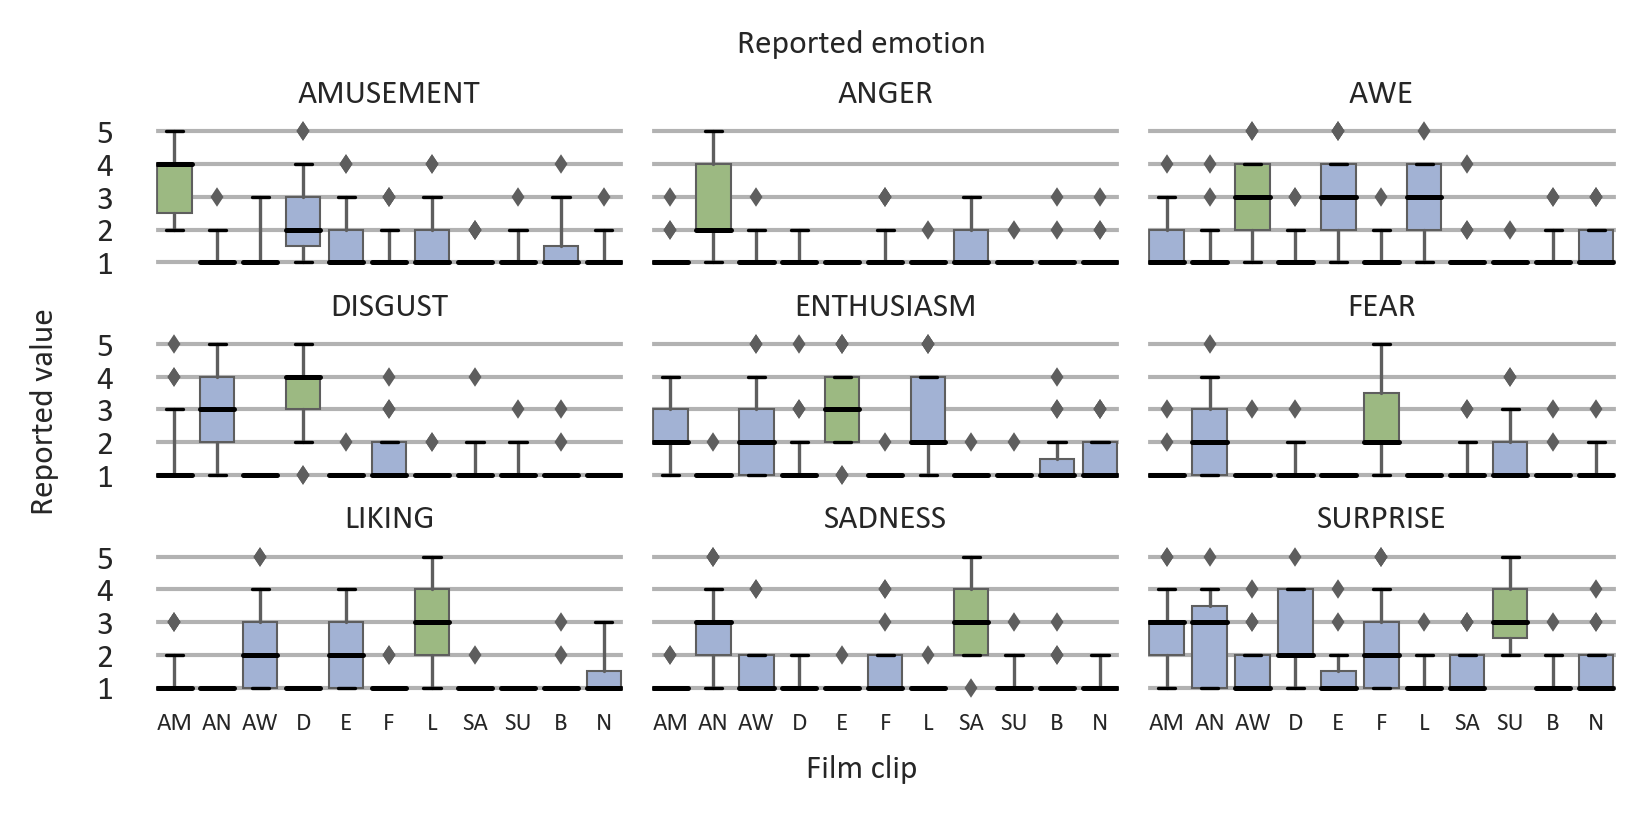

In [13]:
fig = plt.figure(figsize=(6.3, 2.6), constrained_layout=False, dpi=300)
gs0 = fig.add_gridspec(nrows=3, ncols=3, hspace=0.3, wspace=0.05)

for a in range(3):
    for b in range(3):
        fig.add_subplot(gs0[a, b])
        emotion = EMOTIONS[a*3 + b]
        temp_palette = deepcopy(emotions_between_palette)
        temp_palette[a*3 + b] = COLORS[2]
        pos = []
        if b == 0:
            pos.append('left')
        if a == 2:
            pos.append('bottom')
        boxplots_emotions_between(emotions_ratings, emotion, pos, palette=temp_palette)

fig.text(0.5, 0.96, 'Reported emotion', ha='center') # title
fig.text(0.5, 0.03, 'Film clip', ha='center') # xlabel
fig.text(0.06, 0.5, 'Reported value', va='center', rotation='vertical') # ylabel
plt.savefig(SAVE_DIR + 'boxplots-emotions-between', bbox_inches='tight')

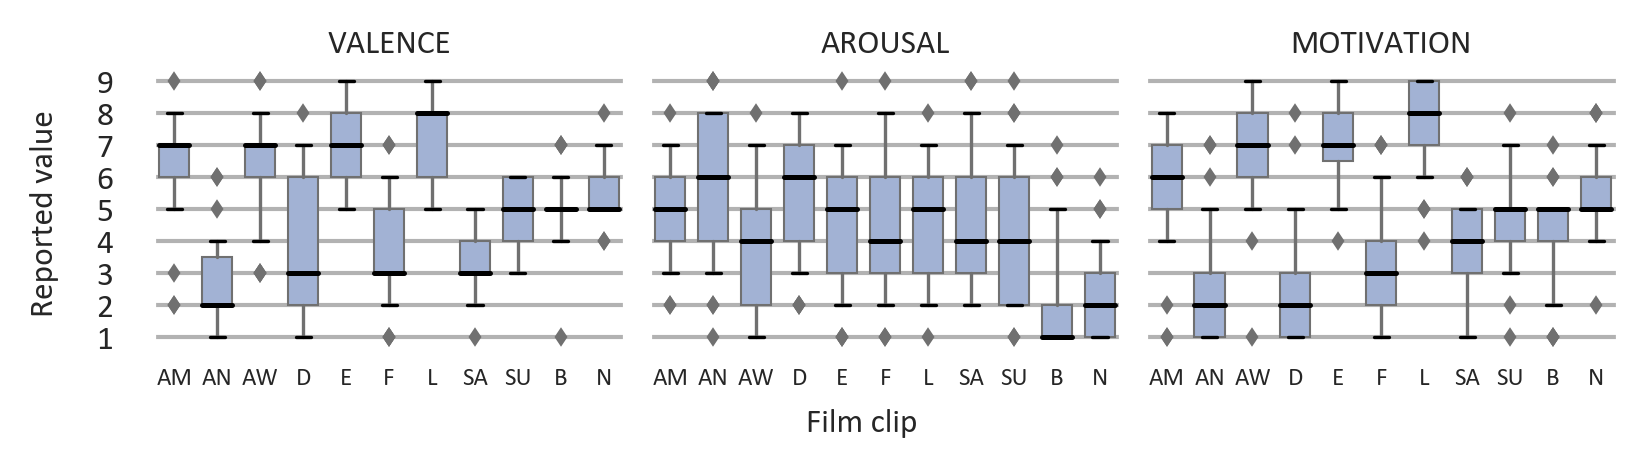

In [14]:
fig = plt.figure(figsize=(6.3, 1.3), constrained_layout=False, dpi=300)
gs0 = fig.add_gridspec(nrows=1, ncols=3, hspace=0.25, wspace=0.05)

for b in range(3):
    fig.add_subplot(gs0[b])
    emotion = EMOTIONS_SAM[b]
    pos = []
    if b == 0:
        pos.append('left')
    boxplots_sam_between(emotions_ratings, emotion, ['bottom'] + pos, palette=sam_between_palette)

fig.text(0.5, -0.06, 'Film clip', ha='center') # xlabel
fig.text(0.06, 0.5, 'Reported value', va='center', rotation='vertical') # ylabel
plt.savefig(SAVE_DIR + 'boxplots-sam-between', bbox_inches='tight')

## Emotions per user
Below we present example heatmaps, comparing participant reported emotions for a chosen stimulant movie.
To generate a full set of heatmaps (each emotion and VAM dimensions between conditions, emotions within each condition) uncomment code fragments in cells and add appropriate indents.

### Emotions within conditions

Text(0.5, 1, 'Emotions within AWE condition')

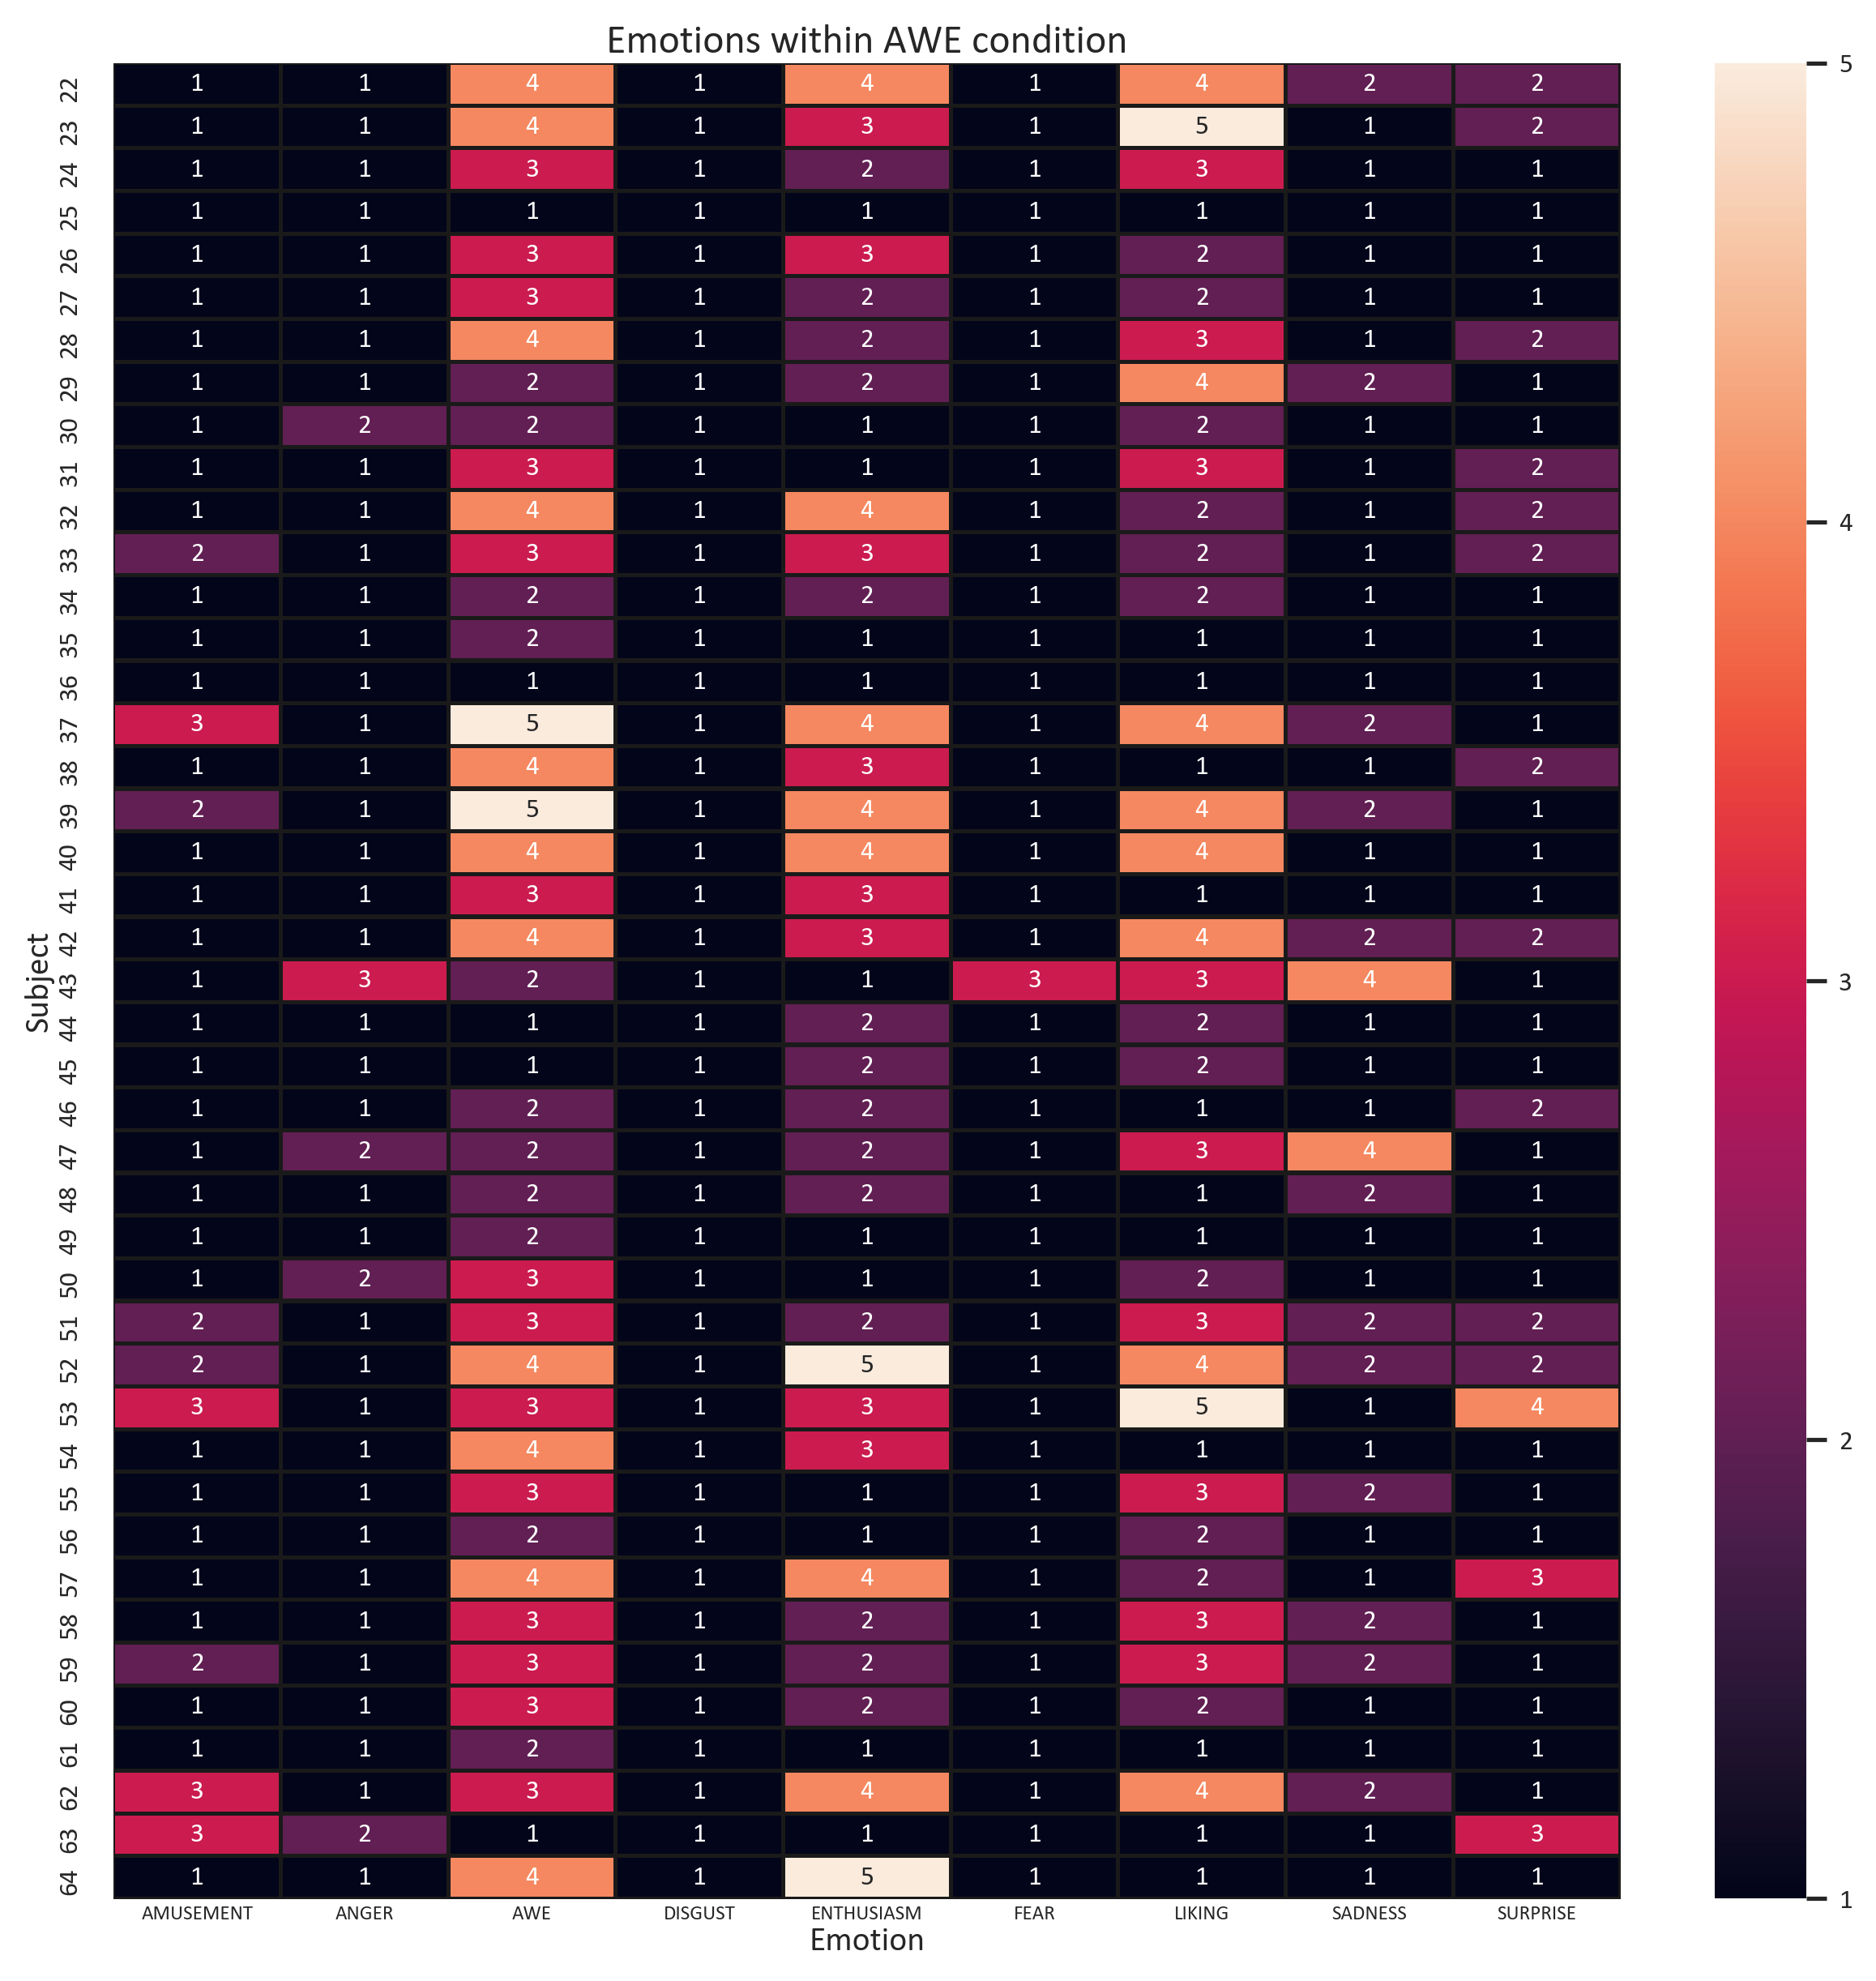

In [15]:
# %%capture

condition = 'AWE' # could be set with any value from EMOTIONS_CATEGORICAL

# for condition in MOVIES:
plt.figure(figsize=(10,10), dpi=300)
ax = sns.heatmap(
    movies_ratings[condition][EMOTIONS].astype(int), 
    annot=True, annot_kws={"size": 8}, fmt='g', linewidths=1, linecolor="k", 
    cbar_kws={"ticks":range(1,6)}, vmin=1, vmax=5
)
cbar = ax.collections[0].colorbar

# ax.collections[0].colorbar.ticks = [1,2,3,4,5]
cbar.ax.tick_params(labelsize=8)
plt.ylabel('Subject', fontsize=10)
plt.xlabel('Emotion', fontsize=10)
plt.title(f'Emotions within {condition} condition', fontsize=12)
#     plt.savefig(SAVE_DIR + f'{condition}_participants_emotions_within_condition.png')

### Emotions between conditions

Text(0.5, 1, 'AWE between conditions')

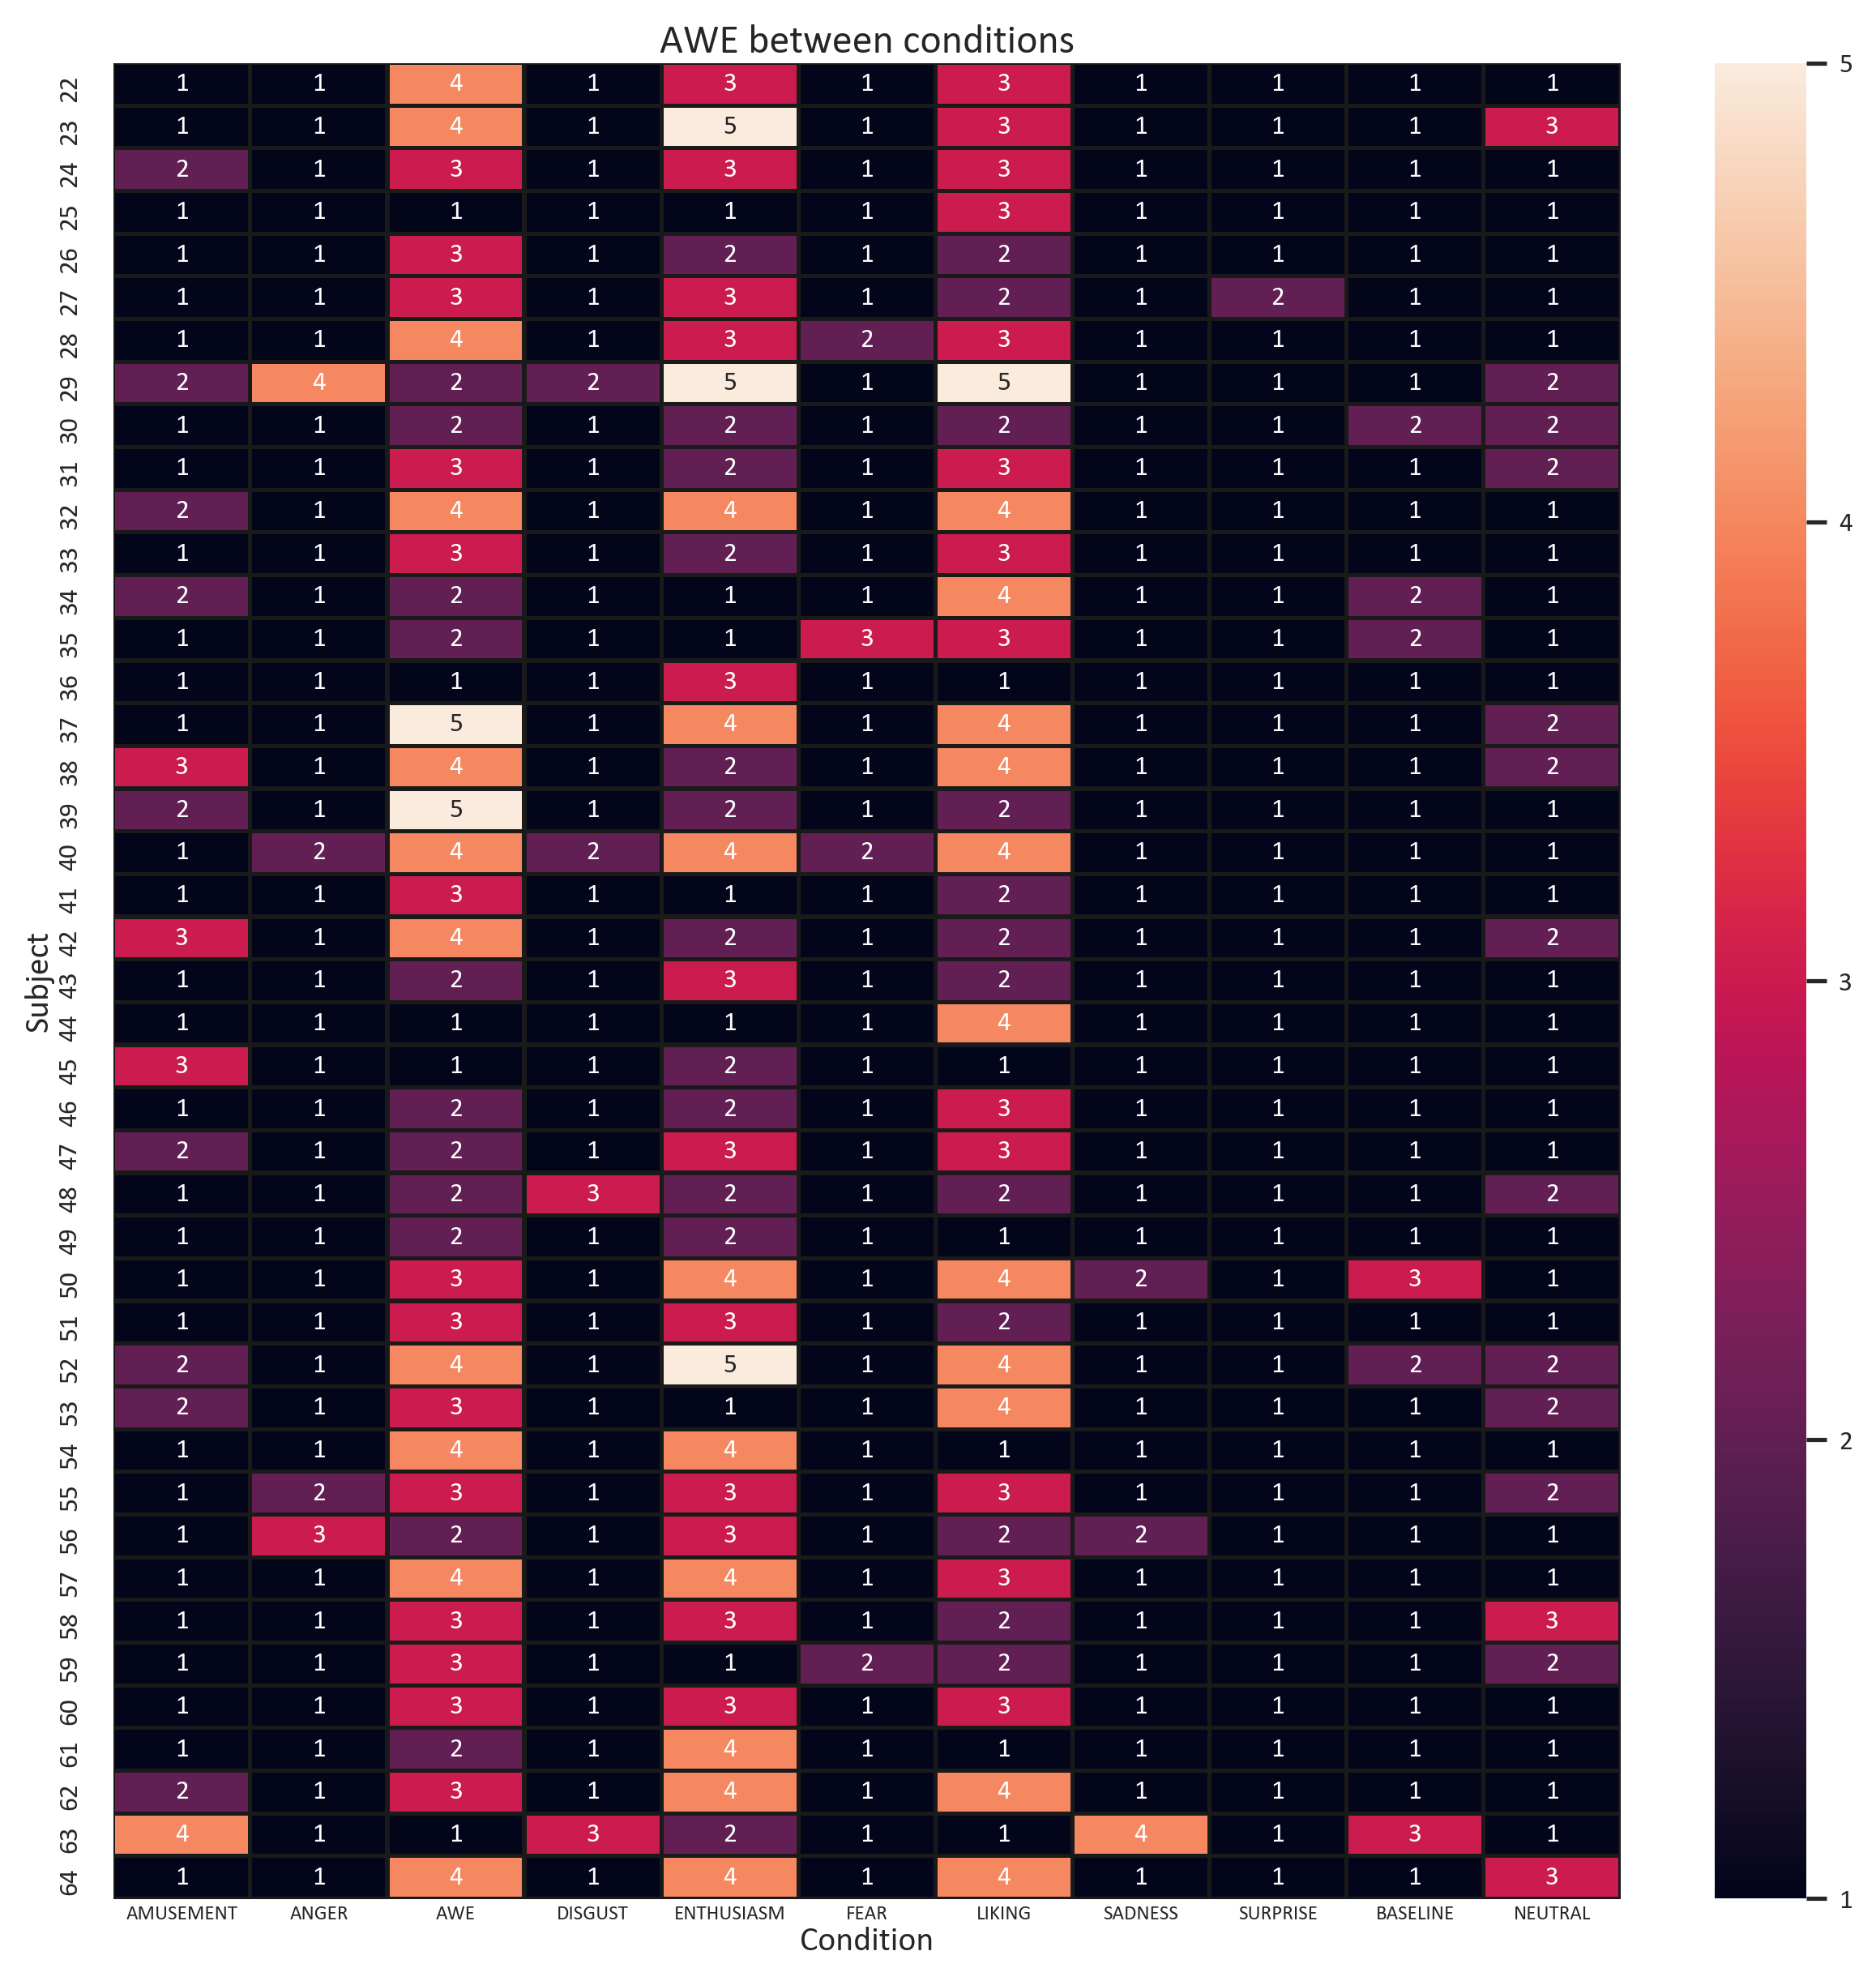

In [16]:
# %%capture

emotion = 'AWE' # could be set with any value from EMOTIONS_CATEGORICAL

# for emotion in EMOTIONS:
plt.figure(figsize=(10,10), dpi=300)
ax = sns.heatmap(
    emotions_ratings[emotion][MOVIES].astype(int), 
    annot=True, annot_kws={"size": 8}, fmt='g', linewidths=1, linecolor="k", 
    cbar_kws={"ticks":range(1,6)}, vmin=1, vmax=5
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
plt.ylabel('Subject', fontsize=10)
plt.xlabel('Condition', fontsize=10)
plt.title(f'{emotion} between conditions', fontsize=12)
#     plt.savefig(SAVE_DIR + f'{emotion}_participants_between_conditions.png')

Text(0.5, 1, 'VALENCE between conditions')

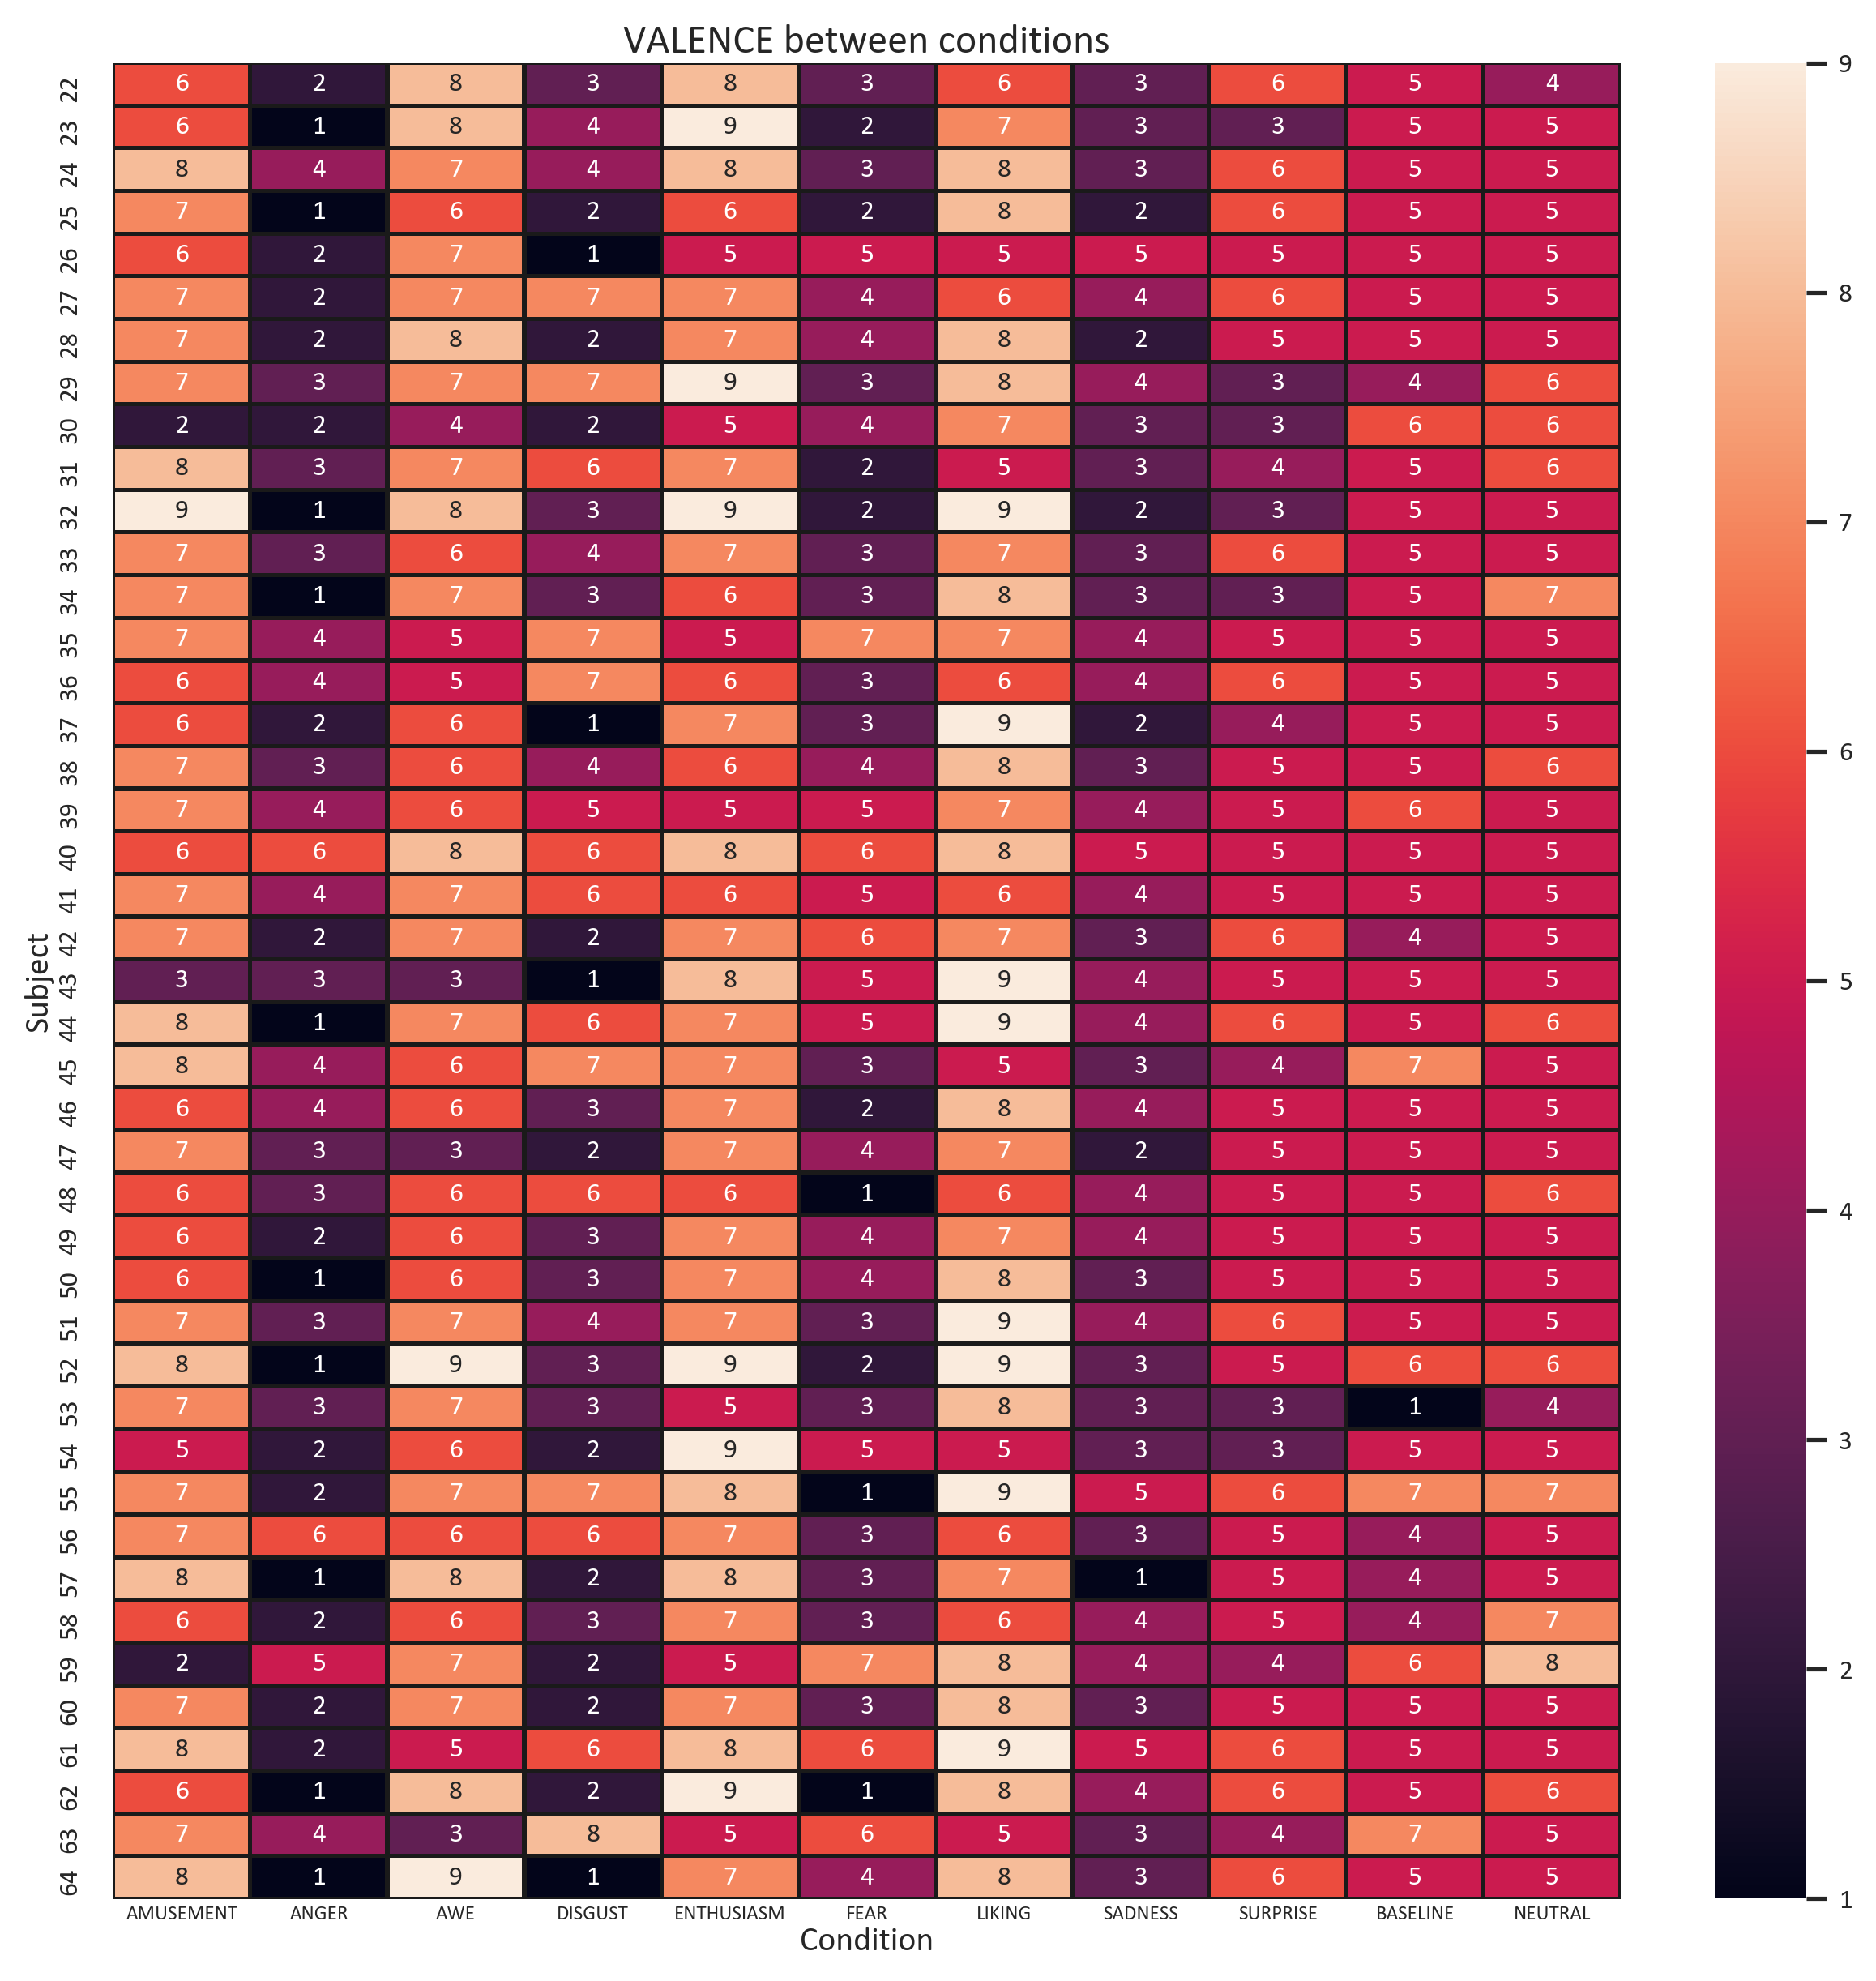

In [17]:
# %%capture

dimension = 'VALENCE' # could be set with any value from EMOTIONS_SAM

# for dimension in EMOTIONS_SAM:
plt.figure(figsize=(10,10), dpi=300)
ax = sns.heatmap(
    emotions_ratings[dimension][MOVIES].astype(int), 
    annot=True, annot_kws={"size": 8}, fmt='g', linewidths=1, linecolor="k", 
    cbar_kws={"ticks":range(1,10)}, vmin=1, vmax=9
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
plt.ylabel('Subject', fontsize=10)
plt.xlabel('Condition', fontsize=10)
plt.title(f'{dimension} between conditions', fontsize=12)
#     plt.savefig(SAVE_DIR + f'{dimension}_participants_between_conditions.png')